# plotting functions of figure 4 in the manuscript


In [1]:
# imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mrcfile

from emmer.pdb.convert.convert_pdb_to_map import convert_pdb_to_map
from emmer.ndimage.filter.low_pass_filter import low_pass_filter
from emmer.ndimage.filter.smoothen_mask import smoothen_mask

# roodmus
from roodmus.analysis.utils import load_data


In [2]:
# functions
def get_precision_per_class(df_truth, df_picked, classification_job):
    result = {
        "class": [],
        "precision": [],
        "number_of_particles": [],
        "picked_fraction": [],
        "fraction_of_true_positives": [],
    }


    num_gt_particles = len(df_truth)
    df_picked_grouped = df_picked.groupby("jobtype").get_group(classification_job).groupby("class2D")
    num_gt_particles_in_picked = len(df_picked.groupby("jobtype").get_group(classification_job).query("TP == True"))
    print(f"number of particles in ground truth: {num_gt_particles}")
    print(f"number of particles in picked: {num_gt_particles_in_picked}")
    num_picked_particles = len(df_picked.groupby("jobtype").get_group(classification_job))
    for class2d in df_picked_grouped.groups:
        particles_in_class = len(df_picked_grouped.get_group(class2d))
        print(f"number of picked particles in class {class2d}: {particles_in_class}. Fraction of picked particles: {np.round(particles_in_class / num_picked_particles, 2)}")
        TP_in_class = len(df_picked_grouped.get_group(class2d).query("TP == True"))
        precision_in_class = TP_in_class / particles_in_class
        print(f"precision in class {class2d}: {np.round(precision_in_class, 2)}")
        print(f"TP fraction in class: {np.round(TP_in_class / num_gt_particles_in_picked, 2)}")
        print(f"test: {np.round((TP_in_class/num_gt_particles_in_picked) / (particles_in_class/num_picked_particles), 2)}")

        result["class"].append(int(class2d))
        result["precision"].append(precision_in_class)
        result["number_of_particles"].append(particles_in_class)
        result["picked_fraction"].append(particles_in_class / num_picked_particles)
        result["fraction_of_true_positives"].append(TP_in_class / num_gt_particles_in_picked)

    df_result = pd.DataFrame(result)
    return df_result


In [3]:
### data loading
# project_dir = "/home/mjoosten1/projects/roodmus/data/DE-Shaw_covid_spike_protein/DESRES-Trajectory_sarscov2-11021566-11021571-mixed"
project_dir = "/tudelft/mjoosten1/staff-umbrella/ajlab/MJ/projects/Roodmus/data/DE-Shaw_covid_spike_protein/DESRES-Trajectory_sarscov2-11021566-11021571-mixed"
config_dir = os.path.join(project_dir, "Micrographs")
meta_files = [
    # os.path.join(project_dir, "Extract", "job004", "particles.star"),
    # os.path.join(project_dir, "Extract", "job009", "particles.star"),
    # os.path.join(project_dir, "Select", "job012", "particles.star"),
    os.path.join(project_dir, "Class3D", "job014", "run_it025_data.star"),
    os.path.join(project_dir, "Class3D", "job037", "run_it025_data.star"),
    os.path.join(project_dir, "Class3D", "job038", "run_it025_data.star"),
]

jobtypes = {
    os.path.join(project_dir, "Extract", "job004", "particles.star"): "LoG",
    os.path.join(project_dir, "Extract", "job009", "particles.star"): "topaz",
    os.path.join(project_dir, "Select", "job012", "particles.star"): "class selection",
    os.path.join(project_dir, "Class3D", "job014", "run_it025_data.star"): "3_classes",
    os.path.join(project_dir, "Class3D", "job037", "run_it025_data.star"): "2_classes",
    os.path.join(project_dir, "Class3D", "job038", "run_it025_data.star"): "10_classes",
}

particle_diameter = 100 # approximate particle diameter in Angstroms
ugraph_shape = (4000, 4000) # shape of the micrograph in pixels. Only needs to be given if the metadata file is a .star file
verbose = True # prints out progress statements
ignore_missing_files = True # if .mrc files are missing, the analysis will still be performed
enable_tqdm = True # enables tqdm progress bars

for i, meta_file in enumerate(meta_files):
    if i == 0:
        analysis = load_data(meta_file, config_dir, particle_diameter, ugraph_shape=ugraph_shape, verbose=verbose, enable_tqdm=enable_tqdm, ignore_missing_files=ignore_missing_files) # creates the class
    else:
        analysis.add_data(meta_file, config_dir, verbose=verbose) # updates the class with the next metadata file

df_picked = pd.DataFrame(analysis.results_picking)
df_truth = pd.DataFrame(analysis.results_truth)
df_precision, df_picked = analysis.compute_precision(df_picked, df_truth, verbose=verbose)
df_picked["jobtype"] = df_picked["metadata_filename"].map(jobtypes)
df_picked_grouped = df_picked.groupby("jobtype")
for group in df_picked_grouped.groups:
    print(f"jobtype: {group}, number of particles: {len(df_picked_grouped.get_group(group))}")

df_precision["jobtype"] = df_precision["metadata_filename"].map(jobtypes)
df_truth["pdb_index"] = df_truth["pdb_filename"].apply(lambda x: int(x.strip(".pdb").split("_")[-1]))

loading metadata from /tudelft/mjoosten1/staff-umbrella/ajlab/MJ/projects/Roodmus/data/DE-Shaw_covid_spike_protein/DESRES-Trajectory_sarscov2-11021566-11021571-mixed/Class3D/job014/run_it025_data.star...
loaded metadata from /tudelft/mjoosten1/staff-umbrella/ajlab/MJ/projects/Roodmus/data/DE-Shaw_covid_spike_protein/DESRES-Trajectory_sarscov2-11021566-11021571-mixed/Class3D/job014/run_it025_data.star. determined file type: star


Dictionaries now contain 105466 reconstructed particles
added 105466 particles from /tudelft/mjoosten1/staff-umbrella/ajlab/MJ/projects/Roodmus/data/DE-Shaw_covid_spike_protein/DESRES-Trajectory_sarscov2-11021566-11021571-mixed/Class3D/job014/run_it025_data.star


loading truth data: 100%|██████████| 400/400 [03:34<00:00,  1.86it/s, micrograph=000399.mrc]


Loaded ground-truth particle positions from config files
Dictionaries now contain 105466 particles and 120000 true particles
Added 120000 particles from /tudelft/mjoosten1/staff-umbrella/ajlab/MJ/projects/Roodmus/data/DE-Shaw_covid_spike_protein/DESRES-Trajectory_sarscov2-11021566-11021571-mixed/Micrographs
loading metadata from /tudelft/mjoosten1/staff-umbrella/ajlab/MJ/projects/Roodmus/data/DE-Shaw_covid_spike_protein/DESRES-Trajectory_sarscov2-11021566-11021571-mixed/Class3D/job037/run_it025_data.star...
loaded metadata from /tudelft/mjoosten1/staff-umbrella/ajlab/MJ/projects/Roodmus/data/DE-Shaw_covid_spike_protein/DESRES-Trajectory_sarscov2-11021566-11021571-mixed/Class3D/job037/run_it025_data.star. determined file type: star
checking if ugraphs exist...


Dictionaries now contain 210932 reconstructed particles
added 105466 particles from /tudelft/mjoosten1/staff-umbrella/ajlab/MJ/projects/Roodmus/data/DE-Shaw_covid_spike_protein/DESRES-Trajectory_sarscov2-11021566-11021571-mixed/

computing precision: 100%|██████████| 1200/1200 [01:19<00:00, 15.09it/s, precision=1, recall=0.924, multiplicity=0.927]    


time taken to compute precision: 80.6284351348877
jobtype: 10_classes, number of particles: 105466
jobtype: 2_classes, number of particles: 105466
jobtype: 3_classes, number of particles: 105466


## panel A
distributions of the particles in each class over the MD trajectories of the open and closed states


number of TP particles in 2_classes: 98329
found 2 classes


/tmp/ipykernel_5605/1053675003.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_picked_grouped["state"] = df_picked_grouped["closest_pdb_index"] <= 8334
/tmp/ipykernel_5605/1053675003.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_picked_grouped["state"] = df_picked_grouped["state"].map({True: "closed", False: "open"})
/tmp/ipykernel_5605/1053675003.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://p

saved figure to: /tudelft/mjoosten1/staff-umbrella/ajlab/MJ/projects/Roodmus/data/DE-Shaw_covid_spike_protein/DESRES-Trajectory_sarscov2-11021566-11021571-mixed/figures/frame_distribution_2_classes.pdf
number of TP particles in 3_classes: 98329
found 3 classes


/tmp/ipykernel_5605/1053675003.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_picked_grouped["state"] = df_picked_grouped["closest_pdb_index"] <= 8334
/tmp/ipykernel_5605/1053675003.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_picked_grouped["state"] = df_picked_grouped["state"].map({True: "closed", False: "open"})
/tmp/ipykernel_5605/1053675003.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://p

saved figure to: /tudelft/mjoosten1/staff-umbrella/ajlab/MJ/projects/Roodmus/data/DE-Shaw_covid_spike_protein/DESRES-Trajectory_sarscov2-11021566-11021571-mixed/figures/frame_distribution_3_classes.pdf
number of TP particles in 10_classes: 98329
found 10 classes


/tmp/ipykernel_5605/1053675003.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_picked_grouped["state"] = df_picked_grouped["closest_pdb_index"] <= 8334
/tmp/ipykernel_5605/1053675003.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_picked_grouped["state"] = df_picked_grouped["state"].map({True: "closed", False: "open"})
/tmp/ipykernel_5605/1053675003.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://p

saved figure to: /tudelft/mjoosten1/staff-umbrella/ajlab/MJ/projects/Roodmus/data/DE-Shaw_covid_spike_protein/DESRES-Trajectory_sarscov2-11021566-11021571-mixed/figures/frame_distribution_10_classes.pdf


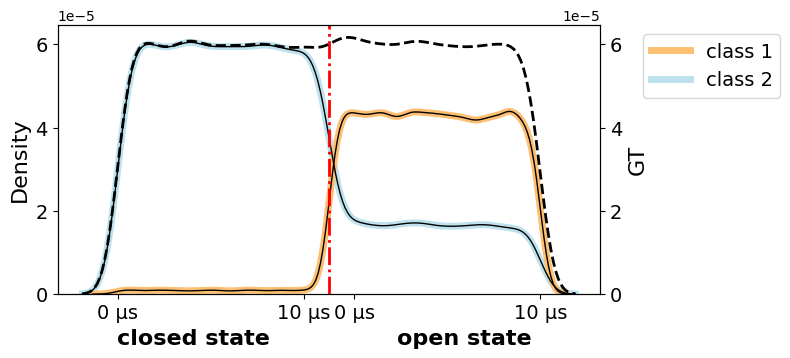

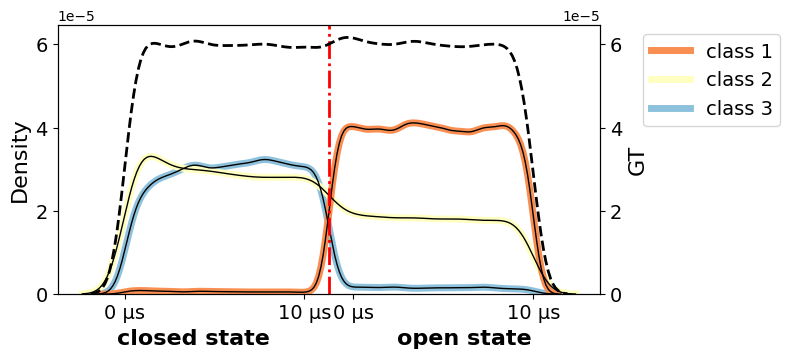

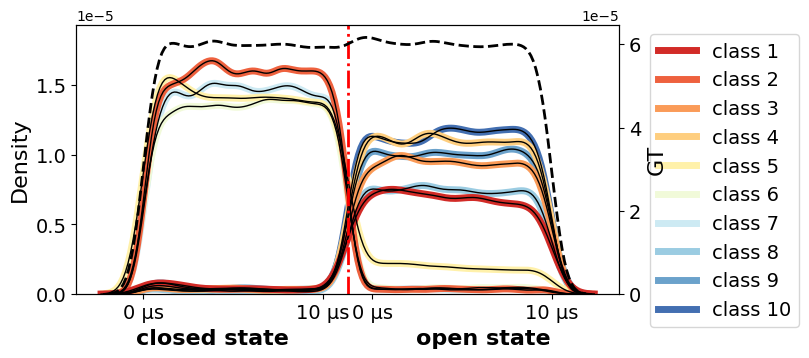

In [4]:
# add a column to the df_picked data frame that indicates if the particles originates from the open or closed state of the spike protein
for classification_job in ["2_classes", "3_classes", "10_classes"]:
    df_truth["pdb_index"] = df_truth["pdb_filename"].apply(lambda x: int(x.strip(".pdb").split("_")[-1]))
    df_picked_grouped = df_picked.groupby(["jobtype", "TP"]).get_group((classification_job,True))
    print(f"number of TP particles in {classification_job}: {len(df_picked_grouped)}")
    # if the closest_pdb_index < 8334, the particle originates from the closed state, otherwise it originates from the open state
    df_picked_grouped["state"] = df_picked_grouped["closest_pdb_index"] <= 8334
    df_picked_grouped["state"] = df_picked_grouped["state"].map({True: "closed", False: "open"})
    # df_picked_grouped["class2D"] = df_picked_grouped["class2D"].astype(int)
    df_picked_grouped.sort_values(by="class2D", inplace=True)
    num_classes = len(df_picked_grouped.groupby("class2D").groups)
    print(f"found {num_classes} classes")
    colors = sns.color_palette("RdYlBu", n_colors=num_classes)

    fig, ax = plt.subplots(figsize=(7, 3.5))
    # make kde plot out of the data
    kde_picked = sns.kdeplot(
        data=df_picked_grouped,
        x="closest_pdb_index",
        ax=ax,
        hue="class2D",
        fill=False,
        label="class2D",
        linewidth=5,
        alpha=1,
        palette=colors,
        legend=True,
    )
    # add an extra black line over the second class
    kde_extra = sns.kdeplot(
        data=df_picked_grouped,
        x="closest_pdb_index",
        ax=ax,
        hue="class2D",
        palette={r+1:"black" for r in range(num_classes)},
        label="picked_particles",
        linewidth=1,
        alpha=1,
        fill=False,
        legend=False,
    )
    # add kdeplot of the True particles
    ax_truth = ax.twinx()
    kde_truth = sns.kdeplot(
        data=df_truth,
        x="pdb_index",
        ax=ax_truth,
        color="black",
        linestyle="--",
        label="GT",
        linewidth=2,
        fill=False,
        alpha=1,
        legend=True,
    )

    # get the legend handles from kde_picked
    handles, labels = ax.get_legend_handles_labels()
    h = [handles[r] for r in range(len(handles)) if labels[r] == "class2D"]
    h = h[::-1]
    h.extend([handles[r] for r in range(len(handles)) if labels[r] == "GT"])
    l = [f"class {r+1}" for r in range(num_classes)] + ["GT"]
    # add the legend
    ax.legend(
        handles=h,
        labels=l,
        loc='upper right',
        bbox_to_anchor=(1.35, 1.0),
        ncol=1,
        fontsize=14,
        frameon=True,
    )
    ax_truth.set_ylabel("GT", fontsize=16)
    if num_classes == 10:
        ylim = ax.get_ylim()
        ax.set_ylim(ylim[0], ylim[1]*1.1)
    else:
        ylim = ax_truth.get_ylim()
        ax.set_ylim(ylim[0], ylim[1])

    # change the xticks to the time in us
    ax.set_xticks([0, 8334-1000, 8334+1000, 16668])
    ax.set_xticklabels(["0 \u03BCs", "10 \u03BCs", "0 \u03BCs", "10 \u03BCs"], fontsize=14)
    ax.axvline(x=8334, color="red", linestyle="-.", linewidth=2)
    ax.set_xlabel("")
    ax.set_ylabel("Density", fontsize=16)
    # label the right side of the plot with 'open state' and the left side with 'closed state' undeneath the x-axis
    ax.text(0.25, -0.2, "closed state", ha='center', va='bottom', fontsize=16, fontweight='bold', transform=ax.transAxes)
    ax.text(0.75, -0.2, "open state", ha='center', va='bottom', fontsize=16, fontweight='bold', transform=ax.transAxes)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax_truth.tick_params(axis='both', which='major', labelsize=14)

    outfilename = os.path.join(project_dir, "figures", f"frame_distribution_{classification_job}.pdf")
    # fig.savefig(outfilename, bbox_inches="tight")
    print(f"saved figure to: {outfilename}")


In [5]:
# for each class print if there are more particles from the open or closed state
for classification_job in ["2_classes", "3_classes", "10_classes"]:
    print(f"jobtype: {classification_job}")
    df_picked_grouped = df_picked.groupby(["jobtype", "TP"]).get_group((classification_job,True))
    df_picked_grouped["state"] = df_picked_grouped["closest_pdb_index"] <= 8334
    df_picked_grouped["state"] = df_picked_grouped["state"].map({True: "closed", False: "open"})
    df_picked_grouped["class2D"] = df_picked_grouped["class2D"].astype(int)
    df_picked_grouped.sort_values(by="class2D", inplace=True)
    num_classes = len(df_picked_grouped.groupby("class2D").groups)

    for class2D in range(1, num_classes+1):
        df_class = df_picked_grouped.groupby("class2D").get_group(class2D)
        num_open = len(df_class.query("state == 'open'"))
        num_closed = len(df_class.query("state == 'closed'"))
        print(f"class {class2D}: {num_open} open, {num_closed} closed")

jobtype: 2_classes
class 1: 35204 open, 746 closed
class 2: 13606 open, 48773 closed
jobtype: 3_classes


/tmp/ipykernel_5605/643096284.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_picked_grouped["state"] = df_picked_grouped["closest_pdb_index"] <= 8334
/tmp/ipykernel_5605/643096284.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_picked_grouped["state"] = df_picked_grouped["state"].map({True: "closed", False: "open"})
/tmp/ipykernel_5605/643096284.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

class 1: 32571 open, 499 closed
class 2: 14999 open, 24710 closed
class 3: 1240 open, 24310 closed
jobtype: 10_classes
class 1: 5758 open, 377 closed
class 2: 277 open, 12849 closed
class 3: 7705 open, 307 closed
class 4: 9010 open, 316 closed
class 5: 1586 open, 11967 closed
class 6: 345 open, 11061 closed
class 7: 294 open, 11817 closed
class 8: 6162 open, 212 closed
class 9: 8293 open, 377 closed
class 10: 9380 open, 236 closed


/tmp/ipykernel_5605/643096284.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_picked_grouped["state"] = df_picked_grouped["closest_pdb_index"] <= 8334
/tmp/ipykernel_5605/643096284.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_picked_grouped["state"] = df_picked_grouped["state"].map({True: "closed", False: "open"})
/tmp/ipykernel_5605/643096284.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

## panel B
plotting the precision of each 3D class

number of particles in ground truth: 120000
number of particles in picked: 98329
number of picked particles in class 1: 36637. Fraction of picked particles: 0.35
precision in class 1: 0.98
TP fraction in class: 0.37
test: 1.05
number of picked particles in class 2: 68829. Fraction of picked particles: 0.65
precision in class 2: 0.91
TP fraction in class: 0.63
test: 0.97
saved figure to: /tudelft/mjoosten1/staff-umbrella/ajlab/MJ/projects/Roodmus/data/DE-Shaw_covid_spike_protein/DESRES-Trajectory_sarscov2-11021566-11021571-mixed/figures/precision_2_classes.pdf
number of particles in ground truth: 120000
number of particles in picked: 98329
number of picked particles in class 1: 33614. Fraction of picked particles: 0.32
precision in class 1: 0.98
TP fraction in class: 0.34
test: 1.06
number of picked particles in class 2: 45947. Fraction of picked particles: 0.44
precision in class 2: 0.86
TP fraction in class: 0.4
test: 0.93
number of picked particles in class 3: 25905. Fraction of pick

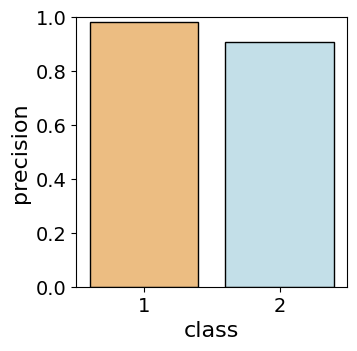

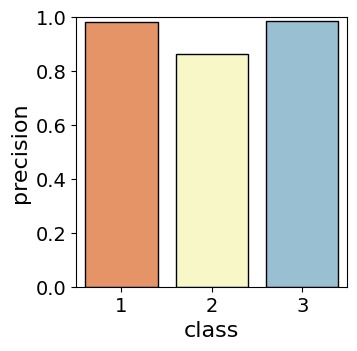

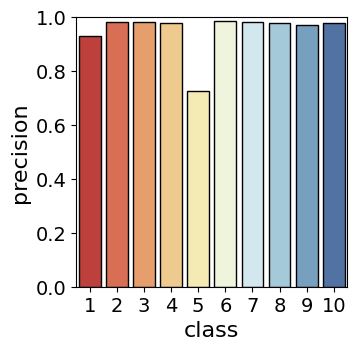

In [6]:
# plot the preicison per 3D class
for classification_job in ["2_classes", "3_classes", "10_classes"]:
    df_result = get_precision_per_class(df_truth, df_picked, classification_job)
    # setup colors
    num_classes = len(df_result["class"].unique())
    colors = sns.color_palette("RdYlBu", n_colors=num_classes)

    fig, ax = plt.subplots(figsize=(3.5, 3.5))
    sns.barplot(
        data=df_result,
        x="class",
        y="precision",
        hue="class",
        palette=colors,
        edgecolor='black',
        ax=ax,
        dodge=0,
        linewidth=1,
    )
    # remove legend
    ax.legend().remove()
    ax.set_ylim((0, 1))
    ax.set_ylabel("precision", fontsize=16)
    ax.set_xlabel("class", fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=14)

    outfilename = os.path.join(project_dir, "figures", f"precision_{classification_job}.pdf")
    # fig.savefig(outfilename, bbox_inches="tight")
    print(f"saved figure to: {outfilename}")


## panel C
plotting the fraction of particles in each class

number of particles in ground truth: 120000
number of particles in picked: 98329
number of picked particles in class 1: 36637. Fraction of picked particles: 0.35
precision in class 1: 0.98
TP fraction in class: 0.37
test: 1.05
number of picked particles in class 2: 68829. Fraction of picked particles: 0.65
precision in class 2: 0.91
TP fraction in class: 0.63
test: 0.97
saved figure to: /tudelft/mjoosten1/staff-umbrella/ajlab/MJ/projects/Roodmus/data/DE-Shaw_covid_spike_protein/DESRES-Trajectory_sarscov2-11021566-11021571-mixed/figures/picked_fraction_2_classes.pdf
number of particles in ground truth: 120000
number of particles in picked: 98329
number of picked particles in class 1: 33614. Fraction of picked particles: 0.32
precision in class 1: 0.98
TP fraction in class: 0.34
test: 1.06
number of picked particles in class 2: 45947. Fraction of picked particles: 0.44
precision in class 2: 0.86
TP fraction in class: 0.4
test: 0.93
number of picked particles in class 3: 25905. Fraction o

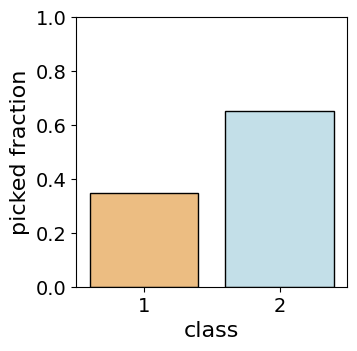

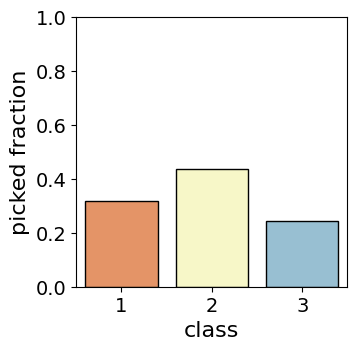

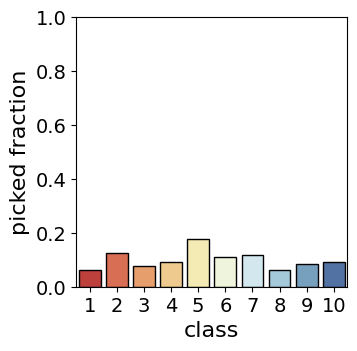

In [7]:
for classification_job in ["2_classes", "3_classes", "10_classes"]:
    df_result = get_precision_per_class(df_truth, df_picked, classification_job)
    # setup colors
    num_classes = len(df_result["class"].unique())
    colors = sns.color_palette("RdYlBu", n_colors=num_classes)

    fig, ax = plt.subplots(figsize=(3.5, 3.5))
    sns.barplot(
        data=df_result,
        x="class",
        y="picked_fraction",
        hue="class",
        palette=colors,
        edgecolor='black',
        ax=ax,
        dodge=0,
        linewidth=1,
    )
    # remove legend
    ax.legend().remove()
    ax.set_ylabel("particle fraction")
    ax.set_ylim((0, 1))
    ax.set_ylabel("picked fraction", fontsize=16)
    ax.set_xlabel("class", fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=14)

    outfilename = os.path.join(project_dir, "figures", f"picked_fraction_{classification_job}.pdf")
    # fig.savefig(outfilename, bbox_inches="tight")
    print(f"saved figure to: {outfilename}")


## panel D
plotting the correlation matrix between each class and a sampling of the frames in the MD trajectory

loading data for 2_classes
number of classes: 2
number of frames: 50
saved figure to: /tudelft/mjoosten1/staff-umbrella/ajlab/MJ/projects/Roodmus/data/DE-Shaw_covid_spike_protein/DESRES-Trajectory_sarscov2-11021566-11021571-mixed/figures/correlation_matrix_2classes.pdf
loading data for 3_classes
number of classes: 3
number of frames: 50
saved figure to: /tudelft/mjoosten1/staff-umbrella/ajlab/MJ/projects/Roodmus/data/DE-Shaw_covid_spike_protein/DESRES-Trajectory_sarscov2-11021566-11021571-mixed/figures/correlation_matrix_3classes.pdf
loading data for 10_classes
number of classes: 10
number of frames: 50
saved figure to: /tudelft/mjoosten1/staff-umbrella/ajlab/MJ/projects/Roodmus/data/DE-Shaw_covid_spike_protein/DESRES-Trajectory_sarscov2-11021566-11021571-mixed/figures/correlation_matrix_10classes.pdf


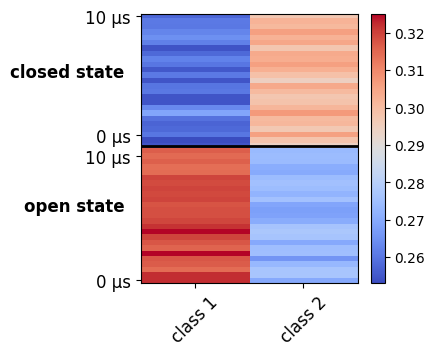

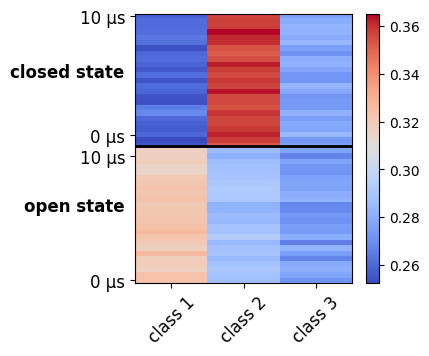

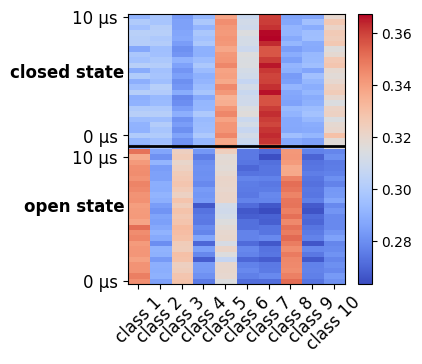

In [8]:

for classification_job in ["2_classes", "3_classes", "10_classes"]:
    print(f"loading data for {classification_job}")
    correlation_matrix_filename = os.path.join(project_dir, "aligned_ensembles", f"correlation_matrix_{classification_job}.npy")
    if os.path.exists(correlation_matrix_filename):
        correlation_matrix = np.load(correlation_matrix_filename)
    else:
        print(f"correlation matrix for {classification_job} does not exist yet. Compute it first.")
    n_classes = correlation_matrix.shape[1]
    n_frames = correlation_matrix.shape[0]
    print(f"number of classes: {n_classes}")
    print(f"number of frames: {n_frames}")

    fig, ax = plt.subplots(figsize=(3.5, 3.5))
    # show the heatmap as a square (~50x3)
    ax.imshow(correlation_matrix, cmap="coolwarm", aspect="auto", origin="lower")
    ticklabels = [f"class {i+1}" for i in range(n_classes)]
    ax.set_xticks(range(n_classes))
    ax.set_xticklabels(ticklabels, fontsize=12, rotation=45)
    ax.set_yticks([0, n_frames//2-2, n_frames//2+2, n_frames-1])
    ax.set_yticklabels(["0 \u03BCs", "10 \u03BCs", "0 \u03BCs", "10 \u03BCs"], fontsize=12)
    ax.axhline(y=n_frames//2, color="black", linestyle="solid", linewidth=2)
    # add colorbar
    cbar = ax.figure.colorbar(ax.get_images()[0], ax=ax, orientation="vertical")
    ax.text(
        -0.65,
        3*n_frames//4,
        "closed state",
        ha='right',
        va='bottom',
        fontsize=12,
        fontweight='bold',
    )
    ax.text(
        -0.65,
        n_frames//4,
        "open state",
        ha='right',
        va='bottom',
        fontsize=12,
        fontweight='bold',
    )

    # save the figure
    outfilename = os.path.join(project_dir, "figures", f"correlation_matrix_{n_classes}classes.pdf")
    # fig.savefig(outfilename, bbox_inches="tight")
    print(f"saved figure to: {outfilename}")

## for text;
to report the resolution in text of the refined maps for the 3class dataset I need to load the generated confidence masks and filter them

In [9]:
# project_dir = "/home/mjoosten1/projects/roodmus/data/DE-Shaw_covid_spike_protein/DESRES-Trajectory_sarscov2-11021566-11021571-mixed"
project_dir = "/tudelft/mjoosten1/staff-umbrella/ajlab/MJ/projects/Roodmus/data/DE-Shaw_covid_spike_protein/DESRES-Trajectory_sarscov2-11021566-11021571-mixed"
data = {
    0:{
        "class": 1,
        "ConfidenceMap": "job103",
    },
    1: {
        "class": 2,
        "ConfidenceMap": "job104",
    },
    2: {
        "class": 3,
        "ConfidenceMap": "job105",
    },
}

for key, item in data.items():
    confidence_map_file = os.path.join(project_dir, "ConfidenceMap", item["ConfidenceMap"], "run_class001_confidenceMap.mrc")
    confidence_map = mrcfile.open(confidence_map_file)
    confidence_mask = confidence_map.data > 0.99

    confidence_mask_smooth = smoothen_mask(
        confidence_mask,
        cosine_falloff_length=5,
    )

    with mrcfile.new(os.path.join(project_dir, "ConfidenceMap", item["ConfidenceMap"], "run_class001_confidenceMap_filtered.mrc"), overwrite=True) as mrc:
        mrc.set_data(confidence_mask_smooth.astype(np.float32))
        mrc.voxel_size = confidence_map.voxel_size
        mrc.header.origin.x = confidence_map.header.origin.x
        mrc.header.origin.y = confidence_map.header.origin.y
        mrc.header.origin.z = confidence_map.header.origin.z